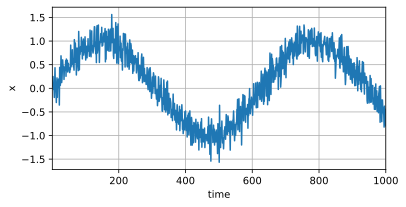

In [41]:
import torch 
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1,1000], figsize = (6, 3))


In [42]:
tau = 4
features = torch.zeros((T-tau, tau))
print(features)
for i in range(tau):
    features[:, i] = x[i:T - tau +i]
labels = x[tau:].reshape((-1, 1))    
print(labels.shape)
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),batch_size,is_train=True)
print(features[:n_train].shape)
print(labels[:n_train].shape)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
torch.Size([996, 1])
torch.Size([600, 4])
torch.Size([600, 1])


In [43]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [44]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
              

net = get_net()
train(net, train_iter, loss, 1000, 0.01)

epoch 1, loss: 0.065087
epoch 2, loss: 0.054723
epoch 3, loss: 0.052525
epoch 4, loss: 0.052775
epoch 5, loss: 0.056196
epoch 6, loss: 0.052625
epoch 7, loss: 0.053148
epoch 8, loss: 0.050700
epoch 9, loss: 0.051993
epoch 10, loss: 0.052725
epoch 11, loss: 0.052635
epoch 12, loss: 0.050893
epoch 13, loss: 0.051591
epoch 14, loss: 0.050702
epoch 15, loss: 0.050637
epoch 16, loss: 0.050453
epoch 17, loss: 0.050446
epoch 18, loss: 0.051743
epoch 19, loss: 0.050945
epoch 20, loss: 0.052062
epoch 21, loss: 0.050549
epoch 22, loss: 0.050227
epoch 23, loss: 0.052975
epoch 24, loss: 0.050810
epoch 25, loss: 0.049976
epoch 26, loss: 0.050017
epoch 27, loss: 0.050008
epoch 28, loss: 0.050478
epoch 29, loss: 0.051317
epoch 30, loss: 0.051004
epoch 31, loss: 0.052283
epoch 32, loss: 0.051931
epoch 33, loss: 0.051390
epoch 34, loss: 0.049978
epoch 35, loss: 0.053354
epoch 36, loss: 0.049758
epoch 37, loss: 0.053886
epoch 38, loss: 0.050866
epoch 39, loss: 0.049784
epoch 40, loss: 0.050706
epoch 41,

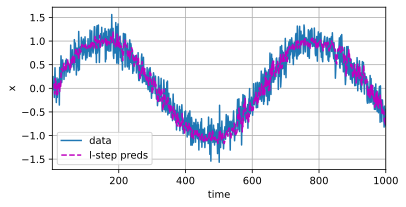

In [45]:
# predict the Seq data
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()],'time', 'x',
    legend=['data', 'l-step preds' ], xlim=[1, 1000], figsize=(6, 3)
)

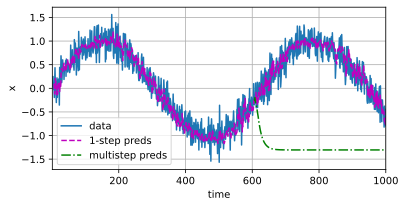

In [46]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

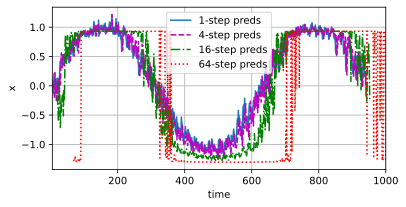

In [47]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3)) 